<a href="https://colab.research.google.com/github/KashanHumayun/Understanding_CLIP_Instructional_PDF_Manuals/blob/main/clip_testing_on_manuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
pip install pymupdf pillow pytesseract torch matplotlib pymupdf paddleocr paddlepaddle clip-by-openai

  Using cached clip_by_openai-1.1-py3-none-any.whl.metadata (369 bytes)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached clip_by_openai-1.0.1-py3-none-any.whl.metadata (407 bytes)
  Using cached clip_by_openai-0.1.1.5-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.4-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.3-py3-none-any.whl.metadata (8.7 kB)
  Using cached clip_by_openai-0.1.1.2-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.1-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.0-py3-none-any.whl.metadata (9.0 kB)
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1

In [23]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-13taz83c
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-13taz83c
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=57227f84f7b85d2f3ea03f6a881117ea6466dee9e63406030cd563362676605a
  Stored in directory: /tmp/pip-ephem-wheel-cache-68daz_m4/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [2]:
import fitz  # PyMuPDF
from PIL import Image
import io
from paddleocr import PaddleOCR
import torch
import clip
import numpy as np


In [3]:
# Load PaddleOCR and CLIP models
ocr = PaddleOCR(use_angle_cls=True, lang='en')
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


/tmp/ipython-input-3-1843786983.py:2: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang='en')
/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:715: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.c

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('UVDoc', None)
The model(UVDoc) is not supported to run in MKLDNN mode! Using `paddle` instead!
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]


In [10]:
def extract_images_and_text(pdf_path):
    doc = fitz.open(pdf_path)
    all_data = []

    for page_num in range(len(doc)):
        page = doc[page_num]
        image_list = page.get_images(full=True)
        # Extract text blocks (from layout)
        text_blocks = [b for b in page.get_text("blocks") if b[4].strip()]

        for img_idx, img in enumerate(image_list):
            xref = img[0]
            base_image = doc.extract_image(xref)
            img_bytes = base_image["image"]
            image = Image.open(io.BytesIO(img_bytes)).convert("RGB")

            # OCR on the image itself (callouts, diagrams)
            ocr_result = ocr.ocr(np.array(image))  # removed cls=True
            # If using ocr.predict instead:
            # ocr_result = ocr.predict(np.array(image))

            ocr_text = ' '.join([line[1][0] for line in ocr_result[0]]) if ocr_result and len(ocr_result[0]) else ''

            all_data.append({
                "page_num": page_num,
                "img_idx": img_idx,
                "image": image,
                "ocr_text": ocr_text,
                "text_blocks": text_blocks,
            })
    return all_data


In [15]:
def embed_image(image):
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features.cpu().numpy().squeeze()
def embed_text(text):
    # tokenize with truncation to avoid RuntimeError
    text_input = clip.tokenize([text], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features.cpu().numpy().squeeze()


def retrieve_top_k(image_features, candidate_texts, k=3):
    scores = []
    for text in candidate_texts:
        text_features = embed_text(text)
        similarity = np.dot(image_features, text_features)
        scores.append((similarity, text))
    top_k = sorted(scores, reverse=True)[:k]
    return top_k




In [12]:
# ----------- Main Pipeline -----------

pdf_path = "/content/Smart-Slide-Doors-Installation-Manual.pdf"
data = extract_images_and_text(pdf_path)


/tmp/ipython-input-10-2298829668.py:18: DeprecationWarning: Please use `predict` instead.
  ocr_result = ocr.ocr(np.array(image))  # removed cls=True
/tmp/ipython-input-10-2298829668.py:18: DeprecationWarning: Please use `predict` instead.
  ocr_result = ocr.ocr(np.array(image))  # removed cls=True
/tmp/ipython-input-10-2298829668.py:18: DeprecationWarning: Please use `predict` instead.
  ocr_result = ocr.ocr(np.array(image))  # removed cls=True
/tmp/ipython-input-10-2298829668.py:18: DeprecationWarning: Please use `predict` instead.
  ocr_result = ocr.ocr(np.array(image))  # removed cls=True
/tmp/ipython-input-10-2298829668.py:18: DeprecationWarning: Please use `predict` instead.
  ocr_result = ocr.ocr(np.array(image))  # removed cls=True
/tmp/ipython-input-10-2298829668.py:18: DeprecationWarning: Please use `predict` instead.
  ocr_result = ocr.ocr(np.array(image))  # removed cls=True
/tmp/ipython-input-10-2298829668.py:18: DeprecationWarning: Please use `predict` instead.
  ocr_resu

In [16]:
def truncate_text(text, max_chars=350):
    return text[:max_chars]

for item in data:
    print(f"Page {item['page_num']} - Image {item['img_idx']}")
    image = item['image']
    image_features = embed_image(image)

    # Truncate all candidate texts for CLIP
    candidate_texts = [truncate_text(b[4]) for b in item['text_blocks']]
    if item['ocr_text'].strip():
        candidate_texts.append(truncate_text(item['ocr_text'].strip()))

    # Get top-3 text matches
    top_matches = retrieve_top_k(image_features, candidate_texts, k=3)
    print("Top matches for this image:")
    for score, txt in top_matches:
        preview = txt.replace('\n', ' ')[:120]
        print(f"  Score: {score:.3f} | Text: {preview}{'...' if len(txt) > 120 else ''}")

    print("=" * 50)


Page 0 - Image 0
Top matches for this image:
  Score: 0.253 | Text: installation instructions Smart Slide Door 
  Score: 0.207 | Text: n a o t o e e e e e e i e e
Page 3 - Image 0
Top matches for this image:
  Score: 0.275 | Text: INSTALLATION:   Proper installation is necessary for this window or door to perform as  designed and rated for water and...
  Score: 0.274 | Text: RECEIVING:   Carefully inspect all windows and doors at the time you receive them and  again at the time you install the...
  Score: 0.270 | Text: BUILDING ENVELOPE:   To minimize the danger of leakage at window openings, various other items,  such as properly config...
Page 3 - Image 1
Top matches for this image:
  Score: 0.265 | Text: BUILDING CODES:   It is the responsibility of the owner, architect, or builder to select and install  products in compli...
  Score: 0.263 | Text: INSTALLATION:   Proper installation is necessary for this window or door to perform as  designed and rated for water and...
  Score: 0.2

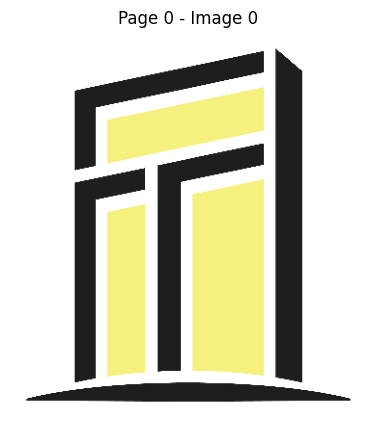

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.253 | Text: installation instructions Smart Slide Door 
  Score: 0.207 | Text: n a o t o e e e e e e i e e


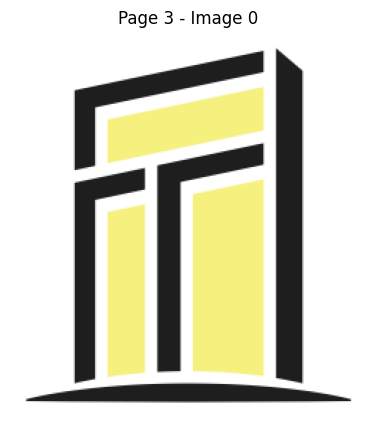

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.275 | Text: INSTALLATION:   Proper installation is necessary for this window or door to perform as  designed and rated for water and...
  Score: 0.274 | Text: RECEIVING:   Carefully inspect all windows and doors at the time you receive them and  again at the time you install the...
  Score: 0.269 | Text: BUILDING CODES:   It is the responsibility of the owner, architect, or builder to select and install  products in compli...


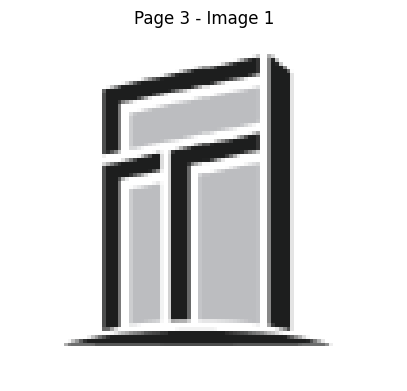

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.265 | Text: BUILDING CODES:   It is the responsibility of the owner, architect, or builder to select and install  products in compli...
  Score: 0.263 | Text: INSTALLATION:   Proper installation is necessary for this window or door to perform as  designed and rated for water and...
  Score: 0.262 | Text: RECEIVING:   Carefully inspect all windows and doors at the time you receive them and  again at the time you install the...


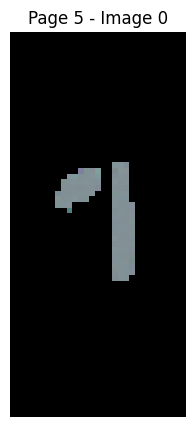

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.248 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.235 | Text: Terminology of tilt & turn window  
  Score: 0.235 | Text: EUROLINE Windows  


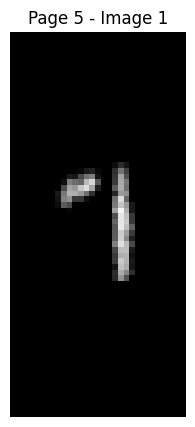

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.242 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.236 | Text: 3  
  Score: 0.232 | Text: Terminology of tilt & turn window  


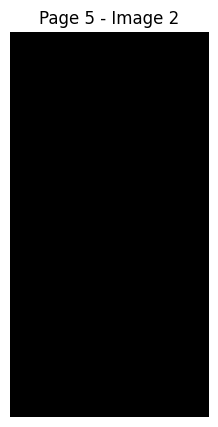

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.256 | Text: turn window  
  Score: 0.256 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.254 | Text: Terminology of tilt & turn window  


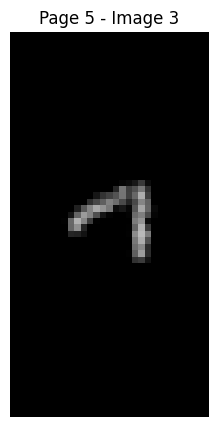

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.255 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.241 | Text: 3  
  Score: 0.240 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...


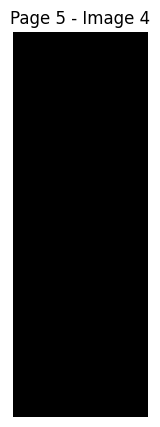

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.256 | Text: turn window  
  Score: 0.256 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.254 | Text: Terminology of tilt & turn window  


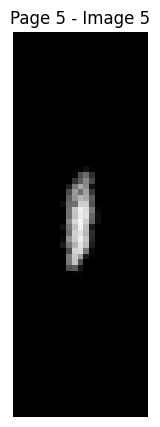

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.239 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.224 | Text: 3  
  Score: 0.219 | Text: EUROLINE Windows  


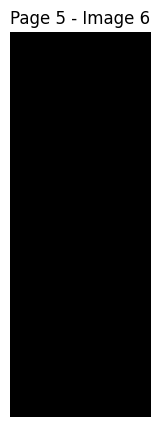

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.256 | Text: turn window  
  Score: 0.256 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.254 | Text: Terminology of tilt & turn window  


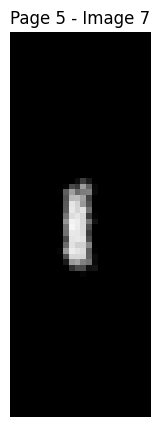

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.246 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.232 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.227 | Text: EUROLINE Windows  


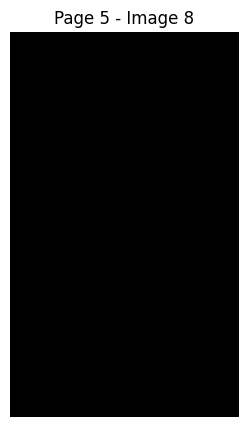

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.256 | Text: turn window  
  Score: 0.256 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.254 | Text: Terminology of tilt & turn window  


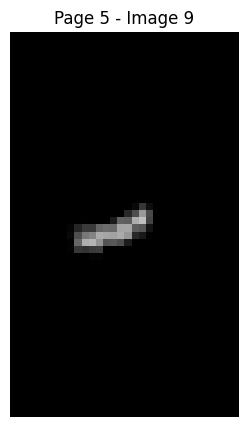

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.243 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.227 | Text: 3  
  Score: 0.224 | Text: EUROLINE Windows  


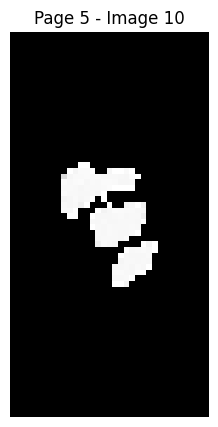

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.241 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.226 | Text: EUROLINE Windows  
  Score: 0.226 | Text: 3  


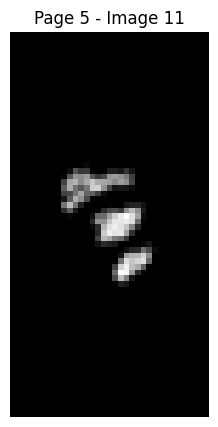

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.243 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.226 | Text: EUROLINE Windows  
  Score: 0.225 | Text: 3  


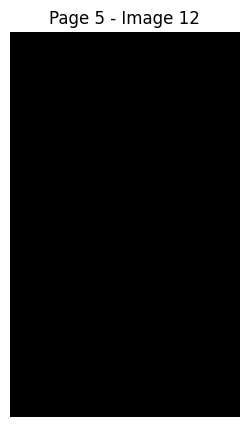

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.256 | Text: turn window  
  Score: 0.256 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.254 | Text: Terminology of tilt & turn window  


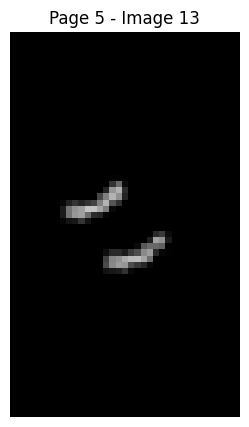

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.240 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.224 | Text: 3  
  Score: 0.220 | Text: EUROLINE Windows  


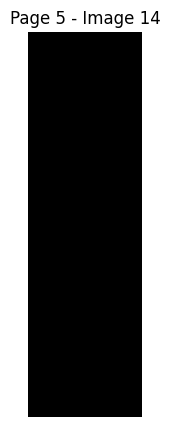

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.256 | Text: turn window  
  Score: 0.256 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.254 | Text: Terminology of tilt & turn window  


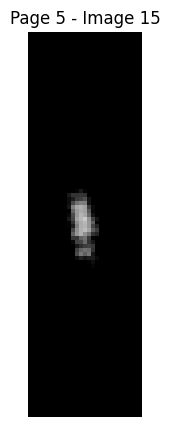

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.241 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.226 | Text: EUROLINE Windows  
  Score: 0.225 | Text: 3  


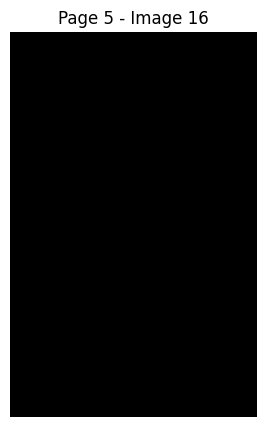

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.256 | Text: turn window  
  Score: 0.256 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.254 | Text: Terminology of tilt & turn window  


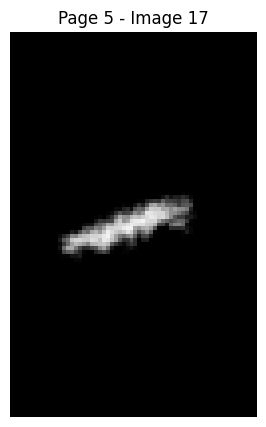

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.228 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.210 | Text: Terminology of tilt & turn window  
  Score: 0.209 | Text: turn window  


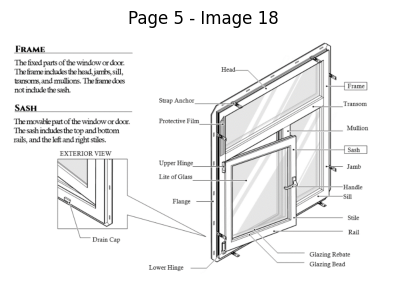

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.312 | Text: The fixed parts of the window or door.  The frame includes the head, jambs, sill,  and mullions. The frame does not incl...
  Score: 0.307 | Text: The movable part of the window or door.  
  Score: 0.291 | Text: Terminology of tilt & turn window  


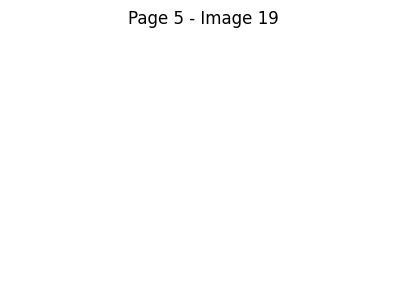

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.232 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.228 | Text: Terminology of tilt & turn window  
  Score: 0.223 | Text: EUROLINE Windows  


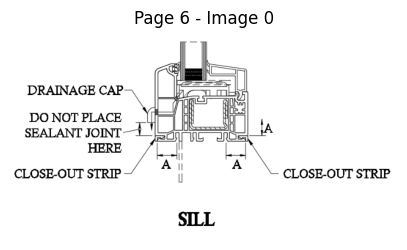

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.298 | Text: To ensure an air and water seal, joint placement is as shown in  one or more of the locations shown “A”.  
  Score: 0.285 | Text: The placement of the sealant joint must be located as shown on the cross- sections below (location “A”). Care must be ta...
  Score: 0.256 | Text: The close-out strip is not designed for air and water tightness.  


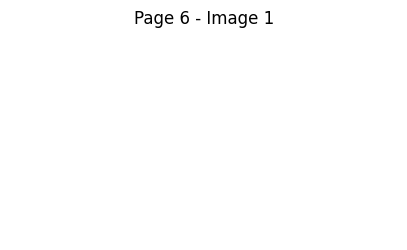

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.233 | Text: Sealants – Important Notes  
  Score: 0.232 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.224 | Text: 4  


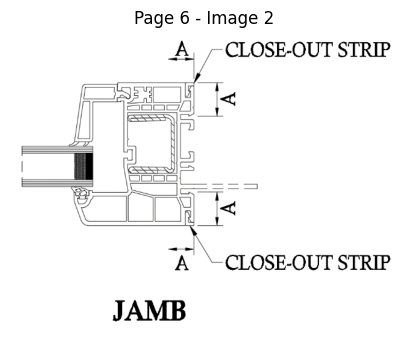

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.350 | Text: The placement of the sealant joint must be located as shown on the cross- sections below (location “A”). Care must be ta...
  Score: 0.332 | Text: To ensure an air and water seal, joint placement is as shown in  one or more of the locations shown “A”.  
  Score: 0.294 | Text: The close-out strip is not designed for air and water tightness.  


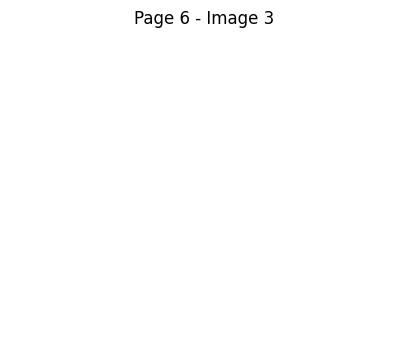

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.233 | Text: Sealants – Important Notes  
  Score: 0.232 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.224 | Text: 4  


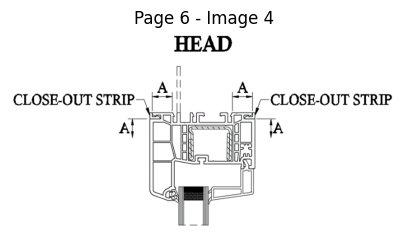

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.315 | Text: To ensure an air and water seal, joint placement is as shown in  one or more of the locations shown “A”.  
  Score: 0.311 | Text: The placement of the sealant joint must be located as shown on the cross- sections below (location “A”). Care must be ta...
  Score: 0.264 | Text: The close-out strip is not designed for air and water tightness.  


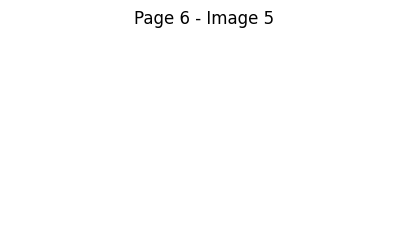

OCR Text: n a o t o e e e e e e i e
---- Top CLIP Matches ----
  Score: 0.233 | Text: Sealants – Important Notes  
  Score: 0.232 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022    
  Score: 0.224 | Text: 4  


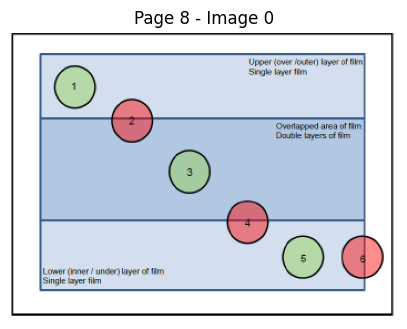

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.254 | Text: 4. Suction cup over any edge of protected area --- Not Recommended 
  Score: 0.248 | Text: 3. Suction cup partially on the overlap and partially on lower layer --- Not Recommended Suction cup completely on lower...
  Score: 0.243 | Text: 2. Suction cup partially on overlap area, partially on upper layer--- Not Recommended Suction cup on completely on overl...


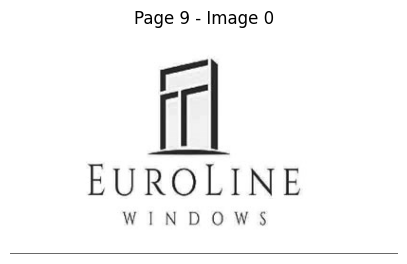

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.364 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022     
  Score: 0.242 | Text: Fastening Through External Perimeter Frame (Denoted by F ) 
  Score: 0.233 | Text: F 


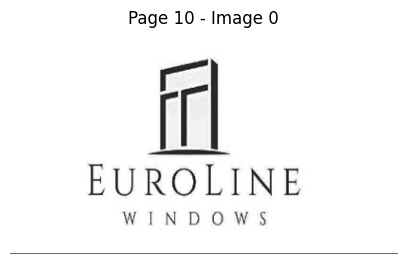

OCR Text: n a o t o e e e e e e i e e
---- Top CLIP Matches ----
  Score: 0.364 | Text: © EuroLine Windows Inc    Instructions Rev. 3  2022     
  Score: 0.233 | Text: F 
  Score: 0.225 | Text: 8  


In [19]:
# ----------- Optional: Show Images & Matches (Visualization) -----------

import matplotlib.pyplot as plt

for item in data:  # Show first 3 examples
    plt.figure(figsize=(5, 5))
    plt.imshow(item["image"])
    plt.axis("off")
    plt.title("Page {} - Image {}".format(item['page_num'], item['img_idx']))
    plt.show()
    print("OCR Text:", item['ocr_text'])
    print("---- Top CLIP Matches ----")
    image_features = embed_image(item["image"])
    candidate_texts = [b[4] for b in item['text_blocks']]
    if item['ocr_text'].strip():
        candidate_texts.append(item['ocr_text'].strip())
    top_matches = retrieve_top_k(image_features, candidate_texts, k=3)
    for score, txt in top_matches:
        preview = txt.replace('\n', ' ')[:120]
        print(f"  Score: {score:.3f} | Text: {preview}{'...' if len(txt) > 120 else ''}")
    print("="*60)
